In [12]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

df = pd.read_json("multinli_1.0_train.jsonl", lines=True)


In [13]:
df[['sentence1', 'sentence2']].iloc[400]

sentence1    Its principal scandal reporter, Ambrose Evans-Pritchard, has published lots of stories on the suicide.
sentence2                       The suicide being covered was caused by a self-inflicted gunshot wound to the head.
Name: 400, dtype: object

In [14]:
df[['annotator_labels']].iloc[400]

annotator_labels    [neutral]
Name: 400, dtype: object

In [15]:
df['genre'].unique()

array(['government', 'telephone', 'fiction', 'travel', 'slate'],
      dtype=object)

In [17]:
df2 = df[df['annotator_labels'].apply(
    lambda x: any(lbl in x for lbl in ['entailment', 'contradiction', 'neutral'])
)].copy()

def map_class(labels):
    if 'contradiction' in labels:
        return 1
    elif 'entailment' in labels:
        return 0
    elif 'neutral' in labels:
        return 2

df2['class'] = df2['annotator_labels'].apply(map_class)


df2['dif'] = (
    df2['sentence1'].str.len() -
    df2['sentence2'].str.len()
).abs()

In [18]:
import re

def common_words_count(s1, s2):
    w1 = set(re.findall(r"\w+", s1.lower()))
    w2 = set(re.findall(r"\w+", s2.lower()))
    return len(w1 & w2)

df2['same'] = df2.apply(
    lambda row: common_words_count(row['sentence1'], row['sentence2']),
    axis=1
)
df['text'] = df['sentence1'] + " " + df['sentence2']

In [22]:
x = df2[[ 'same', 'dif']]
y = df2[['class']]

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=42
)
clf = LogisticRegression(random_state=2).fit(X_train, y_train)
clf.score(X_test, y_test)

/data/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.42102314685136616

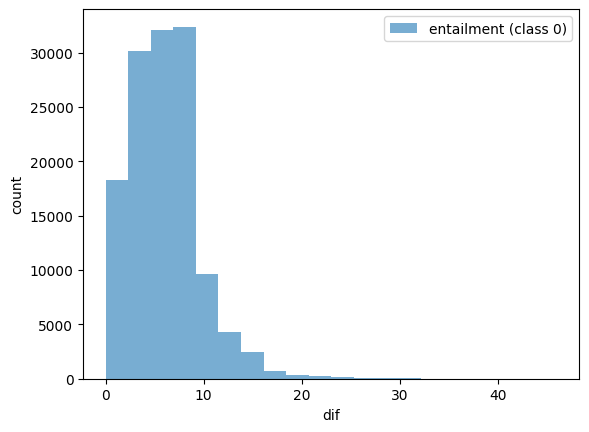

In [ ]:
import matplotlib.pyplot as plt

dif_0 = df2[df2['class'] == 0]['same']  # entailment
dif_1 = df2[df2['class'] == 1]['same']  # contradiction

plt.figure()
plt.hist(dif_0, bins=20, alpha=0.6, label='entailment (class 0)')
plt.xlabel('dif')
plt.ylabel('count')
plt.legend()
plt.show()


# Vectorization

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack  # to concatenate sparse matrices

# Séparer train/test
X_train_s1, X_test_s1, X_train_s2, X_test_s2, y_train, y_test = train_test_split(
    df2['sentence1'], df2['sentence2'], df2['class'], test_size=0.2, random_state=42
)

# TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,  # limite vocabulaire
    ngram_range=(1,2),  # unigrams + bigrams
    stop_words='english'
)

# Vectoriser chaque phrase séparément
X_train_tfidf_s1 = vectorizer.fit_transform(X_train_s1)
X_train_tfidf_s2 = vectorizer.fit_transform(X_train_s2)  # optionally use same vectorizer?

X_test_tfidf_s1 = vectorizer.transform(X_test_s1)
X_test_tfidf_s2 = vectorizer.transform(X_test_s2)

# Concaténer les vecteurs pour chaque paire
X_train_tfidf = hstack([X_train_tfidf_s1, X_train_tfidf_s2])
X_test_tfidf = hstack([X_test_tfidf_s1, X_test_tfidf_s2])

# Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Prédictions
y_pred = clf.predict(X_test_tfidf)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.40      0.38      0.39     26142
           1       0.46      0.42      0.44     26085
           2       0.43      0.49      0.46     26314

    accuracy                           0.43     78541
   macro avg       0.43      0.43      0.43     78541
weighted avg       0.43      0.43      0.43     78541

[[ 9954  6924  9264]
 [ 7332 11021  7732]
 [ 7453  6032 12829]]


In [33]:
clf.score(X_test_tfidf, y_test)

0.4303994092257547